# NB03: Build Link Table & QC

Parse DIAMOND results, resolve multi-clade ambiguities, enrich with conservation
status (core/auxiliary/singleton), and produce the final `fb_pangenome_link.tsv`.

**Runs locally** — no Spark required.

**Inputs**:
- `data/organism_mapping.tsv` (from NB01)
- `data/diamond_hits/<orgId>.tsv` (from run_diamond.sh)
- `data/species_fastas/<clade_id>.fasta` (from NB02, for gene_cluster membership counts)

**Outputs**:
- `data/fb_pangenome_link.tsv` — final link table
- QC plots in `figures/`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob

DATA_DIR = Path('../data')
DIAMOND_DIR = DATA_DIR / 'diamond_hits'
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load organism mapping
mapping = pd.read_csv(DATA_DIR / 'organism_mapping.tsv', sep='\t')
print(f"Organism mapping: {len(mapping)} rows, {mapping['orgId'].nunique()} organisms")

Organism mapping: 498 rows, 44 organisms


## 1. Load DIAMOND Results

In [2]:
# Parse all DIAMOND output files
# outfmt 6: qseqid sseqid pident length qlen slen evalue bitscore
diamond_cols = ['qseqid', 'sseqid', 'pident', 'length', 'qlen', 'slen', 'evalue', 'bitscore']

all_hits = []
per_org_stats = []

hit_files = sorted(DIAMOND_DIR.glob('*.tsv'))
print(f"DIAMOND result files found: {len(hit_files)}")

for f in hit_files:
    orgId = f.stem
    if f.stat().st_size == 0:
        per_org_stats.append({'orgId': orgId, 'n_hits': 0})
        continue
    
    df = pd.read_csv(f, sep='\t', header=None, names=diamond_cols)
    
    # Split qseqid (format: orgId:locusId)
    df[['hit_orgId', 'locusId']] = df['qseqid'].str.split(':', n=1, expand=True)
    df['gene_cluster_id'] = df['sseqid']
    
    all_hits.append(df)
    per_org_stats.append({'orgId': orgId, 'n_hits': len(df)})

hits = pd.concat(all_hits, ignore_index=True) if all_hits else pd.DataFrame()
print(f"Total DIAMOND hits: {len(hits):,}")
print(f"Organisms with hits: {hits['hit_orgId'].nunique() if len(hits) > 0 else 0}")

DIAMOND result files found: 44


Total DIAMOND hits: 192,563
Organisms with hits: 44


In [3]:
# Build gene_cluster_id -> clade_id lookup from species FASTAs
# Each species FASTA file has headers like >gene_cluster_id
cluster_to_clade = {}

species_fasta_dir = DATA_DIR / 'species_fastas'
for fasta_file in species_fasta_dir.glob('*.fasta'):
    clade_id = fasta_file.stem
    with open(fasta_file) as f:
        for line in f:
            if line.startswith('>'):
                cluster_id = line[1:].strip()
                cluster_to_clade[cluster_id] = clade_id

print(f"Built cluster->clade lookup: {len(cluster_to_clade):,} entries")

# Add clade ID to hits
hits['gtdb_species_clade_id'] = hits['gene_cluster_id'].map(cluster_to_clade)
unmapped = hits['gtdb_species_clade_id'].isna().sum()
if unmapped > 0:
    print(f"WARNING: {unmapped} hits without clade mapping")
else:
    print("All hits mapped to clades")

Built cluster->clade lookup: 2,209,907 entries


All hits mapped to clades


## 2. Resolve Multi-Clade Ambiguities

For organisms mapped to multiple pangenome clades, pick the clade with
the most DIAMOND hits and discard hits to other clades.

In [4]:
# Find multi-clade organisms
clades_per_org = mapping.groupby('orgId')['gtdb_species_clade_id'].nunique()
multi_clade_orgs = clades_per_org[clades_per_org > 1].index.tolist()

print(f"Multi-clade organisms: {len(multi_clade_orgs)}")

resolved_clades = {}  # orgId -> chosen clade
resolution_log = []

for orgId in sorted(hits['hit_orgId'].unique()):
    org_clades = mapping[mapping['orgId'] == orgId]['gtdb_species_clade_id'].unique()
    
    if len(org_clades) == 1:
        resolved_clades[orgId] = org_clades[0]
        continue
    
    # Count hits per clade for this organism
    org_hits = hits[hits['hit_orgId'] == orgId]
    hits_per_clade = org_hits.groupby('gtdb_species_clade_id').size().sort_values(ascending=False)
    
    best_clade = hits_per_clade.index[0]
    resolved_clades[orgId] = best_clade
    
    org_info = mapping[mapping['orgId'] == orgId].iloc[0]
    log_entry = {
        'orgId': orgId,
        'genus': org_info['genus'],
        'species': org_info['species'],
        'chosen_clade': best_clade,
        'chosen_hits': hits_per_clade.iloc[0],
        'n_candidate_clades': len(org_clades),
        'all_clades_hits': dict(hits_per_clade)
    }
    resolution_log.append(log_entry)
    
    print(f"\n  {orgId} ({org_info['genus']} {org_info['species']}):")
    for clade, count in hits_per_clade.items():
        marker = ' <-- CHOSEN' if clade == best_clade else ''
        print(f"    {clade}: {count} hits{marker}")

if not resolution_log:
    print("  No multi-clade organisms to resolve")

Multi-clade organisms: 14

  Burk376 (Paraburkholderia bryophila):
    s__Paraburkholderia_bryophila--RS_GCF_003269035.1: 1251 hits <-- CHOSEN
    s__Paraburkholderia_sp000745015--RS_GCF_013409255.1: 1045 hits

  Cup4G11 (Cupriavidus basilensis):
    s__Cupriavidus_basilensis--RS_GCF_008801925.2: 7187 hits <-- CHOSEN
    s__Cupriavidus_basilensis_B--RS_GCF_000876015.1: 20 hits

  Keio (Escherichia coli):
    s__Escherichia_coli_E--RS_GCF_011881725.1: 1083 hits <-- CHOSEN
    s__Escherichia_sp005843885--RS_GCF_005843885.1: 947 hits
    s__Escherichia_ruysiae--GB_GCA_021307345.1: 944 hits
    s__Escherichia_marmotae--RS_GCF_002900365.1: 528 hits
    s__Enterobacter_hormaechei_A--RS_GCF_001729745.1: 190 hits
    s__Citrobacter_freundii--RS_GCF_011064845.1: 139 hits
    s__Klebsiella_variicola--RS_GCF_000828055.2: 62 hits
    s__Enterobacter_roggenkampii--RS_GCF_001729805.1: 35 hits
    s__Klebsiella_quasipneumoniae--RS_GCF_020525925.1: 27 hits
    s__Citrobacter_murliniae--RS_GCF_00103749

In [5]:
# Filter hits to only keep the resolved clade per organism
before_count = len(hits)

hits['resolved_clade'] = hits['hit_orgId'].map(resolved_clades)
hits_filtered = hits[hits['gtdb_species_clade_id'] == hits['resolved_clade']].copy()

print(f"Hits before clade resolution: {before_count:,}")
print(f"Hits after clade resolution:  {len(hits_filtered):,}")
print(f"Removed: {before_count - len(hits_filtered):,} hits from non-chosen clades")

Hits before clade resolution: 192,563
Hits after clade resolution:  177,863
Removed: 14,700 hits from non-chosen clades


## 3. Enrich with Gene Cluster Conservation Status

Classify each gene cluster as core (in ≥95% of species genomes),
auxiliary (<95%, >1 genome), or singleton (1 genome only).

This uses the `no_genomes` and `no_genes` columns from the species FASTA headers
or, if those aren't available, counts genomes from cluster member data.

For now, we compute this from the pangenome metadata cached during NB02.
If a `cluster_metadata.tsv` file exists (exported from Spark), we use that.
Otherwise, we load it from Spark in a future step.

In [6]:
# Try to load cluster metadata if available
cluster_meta_path = DATA_DIR / 'cluster_metadata.tsv'

if cluster_meta_path.exists():
    cluster_meta = pd.read_csv(cluster_meta_path, sep='\t')
    print(f"Loaded cluster metadata: {len(cluster_meta):,} clusters")
else:
    print("No cluster_metadata.tsv found.")
    print("To generate it, run this on JupyterHub:")
    print()
    
    # Generate the query for the user
    unique_clades = list(set(resolved_clades.values()))
    clade_str = "','".join(unique_clades)
    print(f"""spark.sql(\"\"\"""")
    print(f"""    SELECT gc.gene_cluster_id, gc.gtdb_species_clade_id,""")
    print(f"""           gc.no_genomes, gc.no_genes,""")
    print(f"""           p.no_genomes as species_total_genomes""")
    print(f"""    FROM kbase_ke_pangenome.gene_cluster gc""")
    print(f"""    JOIN kbase_ke_pangenome.pangenome p""")
    print(f"""        ON gc.gtdb_species_clade_id = p.gtdb_species_clade_id""")
    print(f"""    WHERE gc.gtdb_species_clade_id IN ('{clade_str}')""")
    print(f"""\"\"\").toPandas().to_csv('data/cluster_metadata.tsv', sep='\\t', index=False)""")
    print()
    print("Then re-run this cell.")
    cluster_meta = None

Loaded cluster metadata: 2,209,907 clusters


In [7]:
if cluster_meta is not None:
    # is_core, is_auxiliary, is_singleton are already in the metadata
    print("Cluster classification:")
    print(f"  Core:      {cluster_meta['is_core'].sum():>10,}  "
          f"({cluster_meta['is_core'].mean()*100:.1f}%)")
    print(f"  Auxiliary:  {cluster_meta['is_auxiliary'].sum():>10,}  "
          f"({cluster_meta['is_auxiliary'].mean()*100:.1f}%)")
    print(f"  Singleton:  {cluster_meta['is_singleton'].sum():>10,}  "
          f"({cluster_meta['is_singleton'].mean()*100:.1f}%)")

    # Merge with hits
    hits_enriched = hits_filtered.merge(
        cluster_meta[['gene_cluster_id', 'is_core', 'is_auxiliary', 'is_singleton']],
        on='gene_cluster_id',
        how='left'
    )
    print(f"\nEnriched hits: {len(hits_enriched):,}")
    print(f"  with conservation data: {hits_enriched['is_core'].notna().sum():,}")
else:
    print("Skipping enrichment — no cluster metadata available")
    hits_enriched = hits_filtered.copy()
    hits_enriched['is_core'] = None
    hits_enriched['is_auxiliary'] = None
    hits_enriched['is_singleton'] = None

Cluster classification:
  Core:         682,965  (30.9%)
  Auxiliary:   1,526,942  (69.1%)
  Singleton:     909,096  (41.1%)



Enriched hits: 177,863
  with conservation data: 177,863


## 4. Build Final Link Table

In [8]:
# Select and rename columns for final table
link_table = hits_enriched[[
    'hit_orgId', 'locusId', 'gene_cluster_id', 'resolved_clade',
    'pident', 'evalue', 'bitscore',
    'is_core', 'is_auxiliary', 'is_singleton'
]].rename(columns={
    'hit_orgId': 'orgId',
    'resolved_clade': 'gtdb_species_clade_id'
})

# Sort for readability
link_table = link_table.sort_values(['orgId', 'locusId']).reset_index(drop=True)

print(f"Final link table: {len(link_table):,} rows")
print(f"Unique organisms: {link_table['orgId'].nunique()}")
print(f"Unique gene clusters: {link_table['gene_cluster_id'].nunique():,}")
link_table.head(10)

Final link table: 177,863 rows
Unique organisms: 44
Unique gene clusters: 163,974


,orgId,locusId,gene_cluster_id,gtdb_species_clade_id,pident,evalue,bitscore,is_core,is_auxiliary,is_singleton
0,ANA3,7022495,NC_008573.1_1,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,1.210000e-213,585.0,False,True,True
1,ANA3,7022496,NC_008573.1_2,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,2.580000e-50,149.0,False,True,True
2,ANA3,7022497,NC_008573.1_3,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,2.080000e-241,653.0,False,True,True
3,ANA3,7022498,NC_008573.1_4,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,5.440000e-66,191.0,False,True,True
4,ANA3,7022499,NC_008573.1_5,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,4.440000e-84,238.0,False,True,True
5,ANA3,7022500,NC_008573.1_6,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,0.000000e+00,1452.0,False,True,True
6,ANA3,7022501,NC_008573.1_7,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,1.730000e-153,423.0,False,True,True
7,ANA3,7022502,NC_008573.1_8,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,8.110000e-305,820.0,False,True,True
8,ANA3,7022503,NC_008573.1_9,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,1.520000e-92,261.0,False,True,True
9,ANA3,7022504,NZ_NAJR01000019.1_39,s__Shewanella_sp000203935--RS_GCF_000203935.1,99.5,2.860000e-271,732.0,False,True,False


In [9]:
# Save link table
output_path = DATA_DIR / 'fb_pangenome_link.tsv'
link_table.to_csv(output_path, sep='\t', index=False)
print(f"Saved: {output_path}")
print(f"  {len(link_table):,} rows")

Saved: ../data/fb_pangenome_link.tsv
  177,863 rows


## 5. Quality Control

In [10]:
# Per-organism coverage: % of FB genes matched
# Count total FB genes per organism from the FB FASTA files
fb_fasta_dir = DATA_DIR / 'fb_fastas'

fb_gene_counts = {}
for f in fb_fasta_dir.glob('*.fasta'):
    orgId = f.stem
    n = sum(1 for line in open(f) if line.startswith('>'))
    fb_gene_counts[orgId] = n

# Build per-organism summary
matched_counts = link_table.groupby('orgId').size().to_dict()
median_pident = link_table.groupby('orgId')['pident'].median().to_dict()

summary_rows = []
for orgId in sorted(set(list(fb_gene_counts.keys()) + list(matched_counts.keys()))):
    n_total = fb_gene_counts.get(orgId, 0)
    n_matched = matched_counts.get(orgId, 0)
    pct = (n_matched / n_total * 100) if n_total > 0 else 0
    clade = resolved_clades.get(orgId, 'unmapped')
    summary_rows.append({
        'orgId': orgId,
        'n_genes': n_total,
        'n_matched': n_matched,
        'pct_matched': round(pct, 1),
        'median_pident': round(median_pident.get(orgId, 0), 1),
        'resolved_clade': clade
    })

summary = pd.DataFrame(summary_rows).sort_values('pct_matched', ascending=False)

print("=== PER-ORGANISM COVERAGE ===")
print(summary.to_string(index=False))

# Flag low-coverage organisms
low_cov = summary[summary['pct_matched'] < 80]
if len(low_cov) > 0:
    print(f"\nWARNING: {len(low_cov)} organisms with <80% coverage:")
    print(low_cov[['orgId', 'n_genes', 'n_matched', 'pct_matched']].to_string(index=False))

=== PER-ORGANISM COVERAGE ===
                  orgId  n_genes  n_matched  pct_matched  median_pident                                       resolved_clade
                 psRCH2     4265       4238         99.4          100.0     s__Stutzerimonas_stutzeri_AE--RS_GCF_000327065.1
                     PS     3443       3418         99.3           99.9               s__Azospira_oryzae--RS_GCF_004217225.1
                  Korea     4149       4116         99.2           99.7        s__Sphingomonas_koreensis--RS_GCF_002797435.1
                   ANA3     4360       4315         99.0           99.6        s__Shewanella_sp000203935--RS_GCF_000203935.1
                 WCS417     5506       5451         99.0          100.0          s__Pseudomonas_E_simiae--RS_GCF_900111895.1
          SyringaeB728a     5089       5031         98.9           99.7      s__Pseudomonas_E_syringae_M--RS_GCF_009176725.1
                   SynE     2669       2636         98.8          100.0       s__Synechococcus_

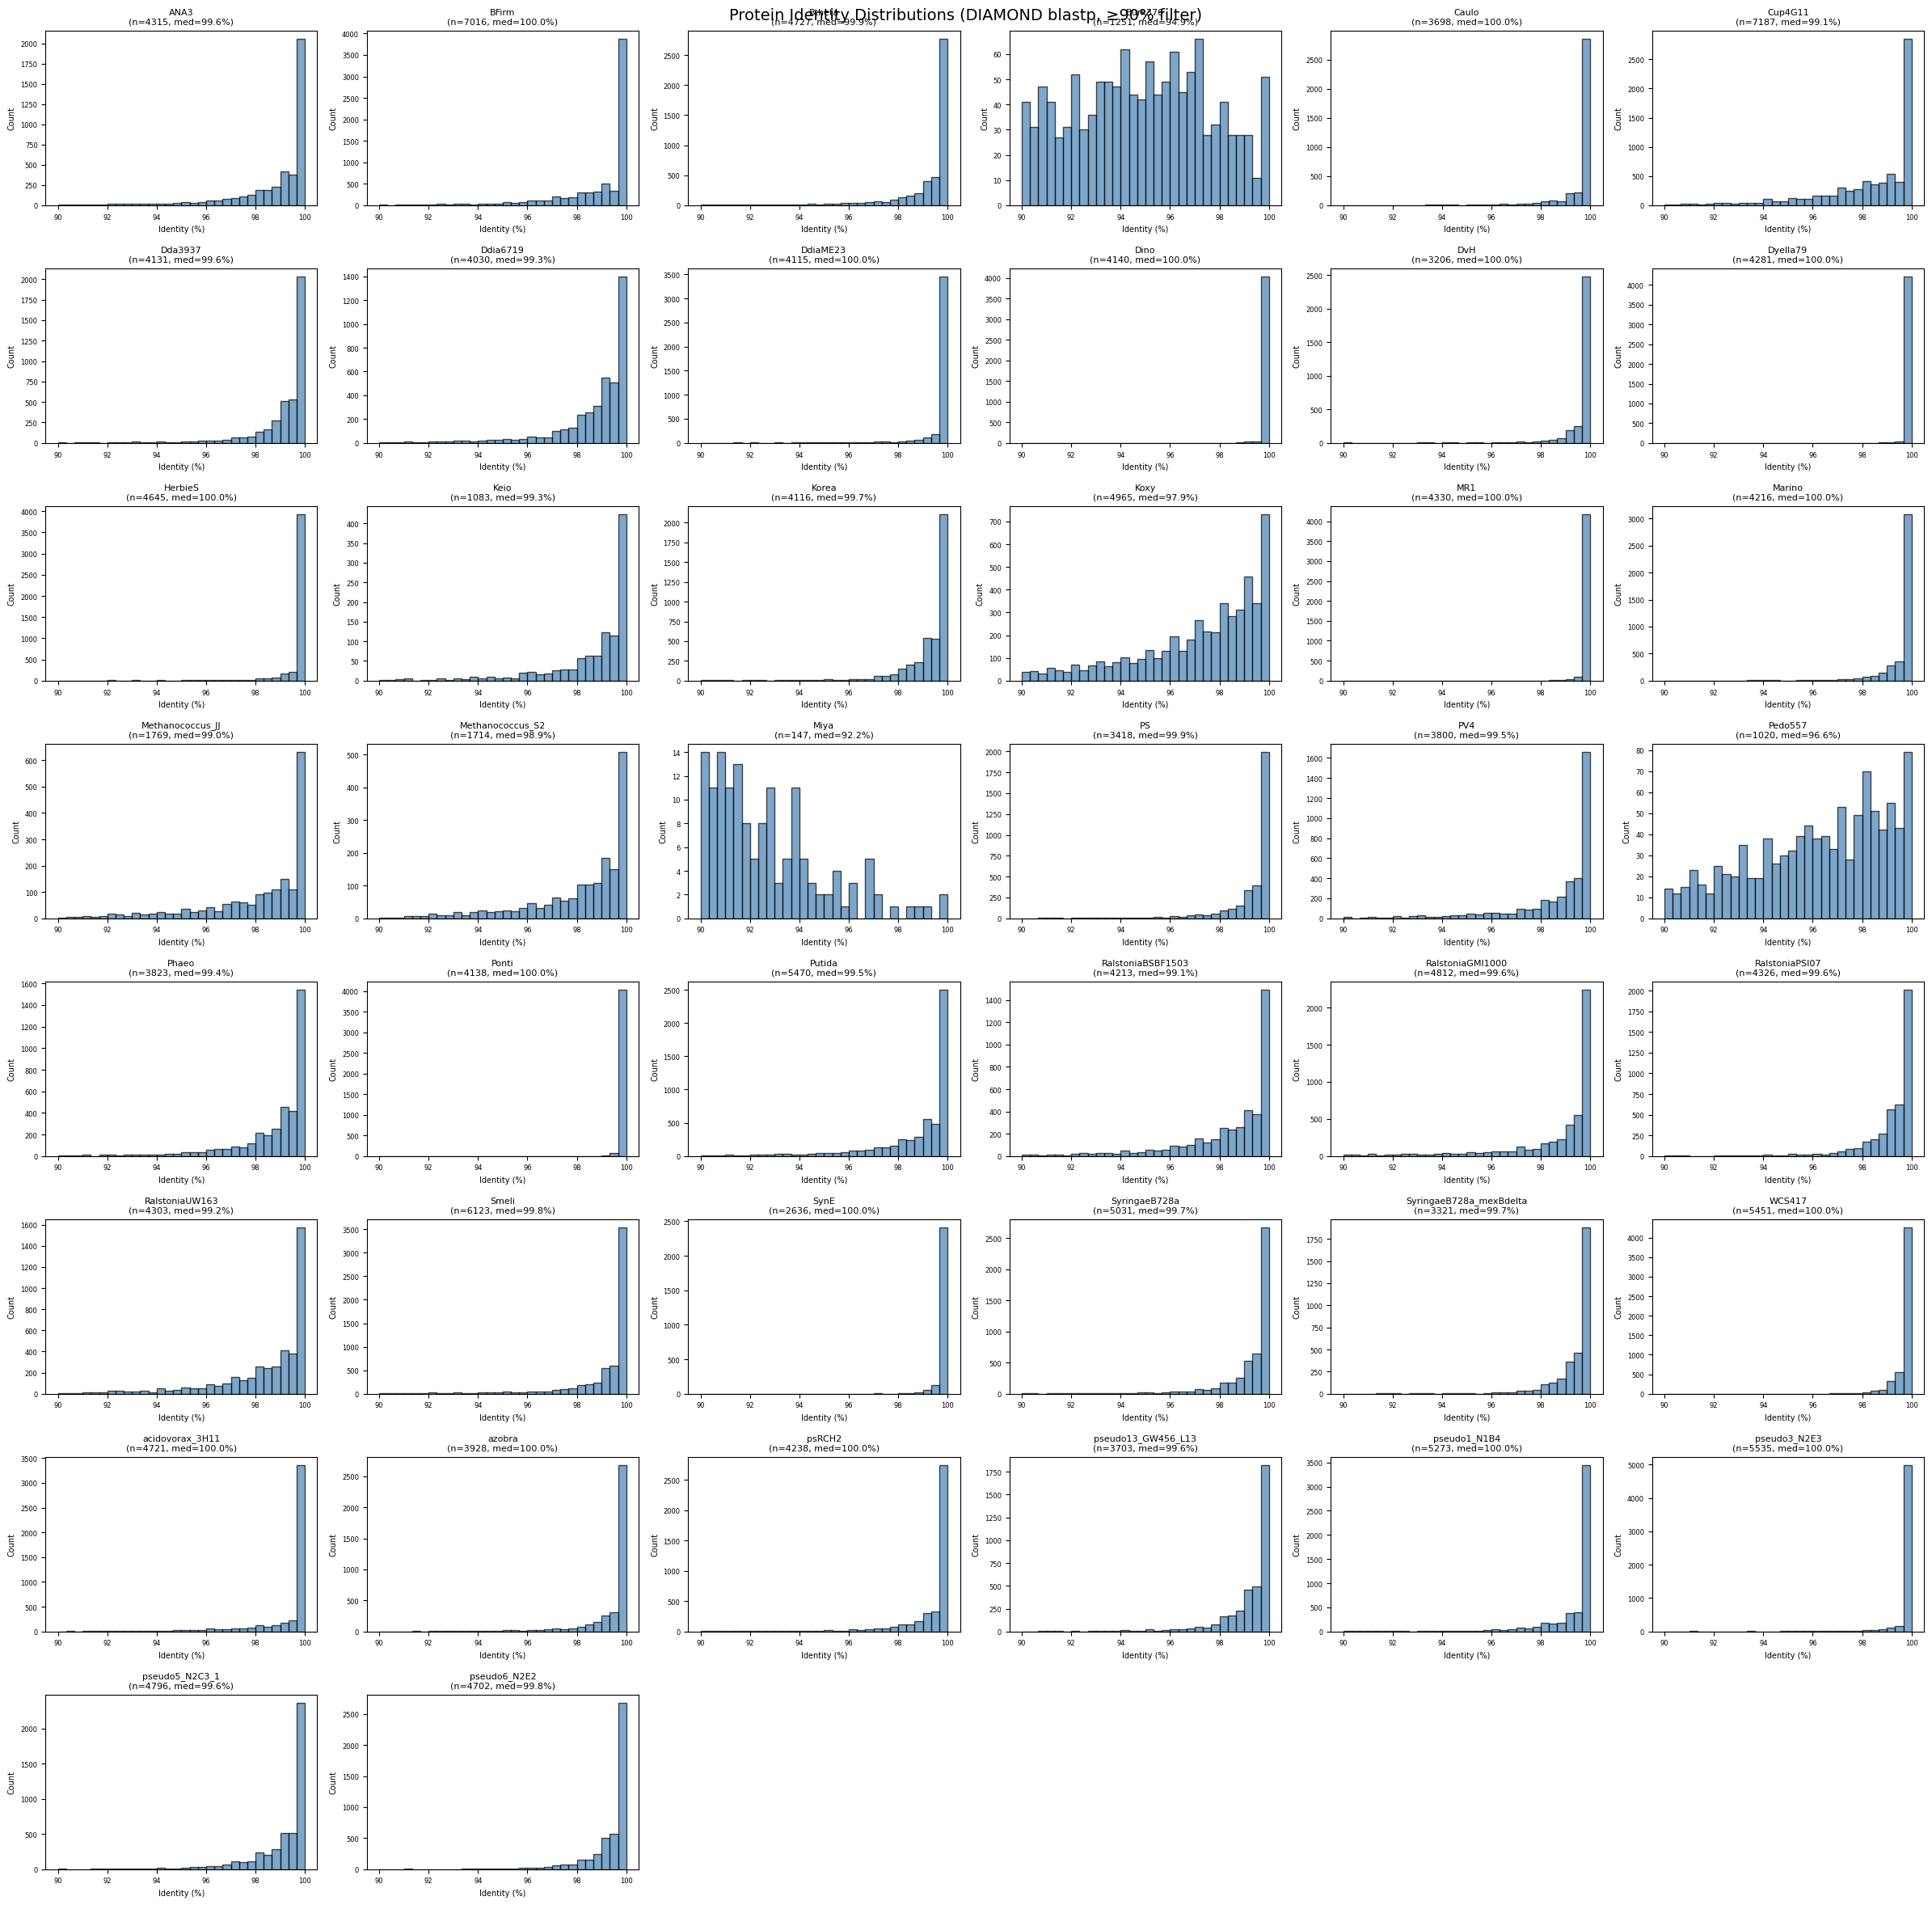

In [11]:
# Identity distribution per organism (expect peaks near 100%)
orgs_to_plot = link_table['orgId'].unique()
n_orgs = len(orgs_to_plot)
ncols = 6
nrows = (n_orgs + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = axes.flatten() if n_orgs > 1 else [axes]

for idx, orgId in enumerate(sorted(orgs_to_plot)):
    org_data = link_table[link_table['orgId'] == orgId]
    axes[idx].hist(org_data['pident'], bins=30, range=(90, 100),
                   edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f"{orgId}\n(n={len(org_data)}, med={org_data['pident'].median():.1f}%)",
                        fontsize=8)
    axes[idx].set_xlabel('Identity (%)', fontsize=7)
    axes[idx].set_ylabel('Count', fontsize=7)
    axes[idx].tick_params(labelsize=6)

# Hide unused subplots
for idx in range(n_orgs, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Protein Identity Distributions (DIAMOND blastp, ≥90% filter)', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'identity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

=== CONSERVATION BREAKDOWN PER ORGANISM ===
                  orgId  n_core  n_auxiliary  n_singleton  n_total  pct_core  pct_singleton
                   ANA3    3413          902          486     4315      79.1           11.3
                  BFirm    5284         1732         1176     7016      75.3           16.8
                 Btheta    3095         1632           98     4727      65.5            2.1
                Burk376    1234           17            7     1251      98.6            0.6
                  Caulo    3363          335            8     3698      90.9            0.2
                Cup4G11    4634         2553         1481     7187      64.5           20.6
                Dda3937    3392          739           86     4131      82.1            2.1
               Ddia6719    3263          767          383     4030      81.0            9.5
               DdiaME23    3490          625           20     4115      84.8            0.5
                   Dino    4140     

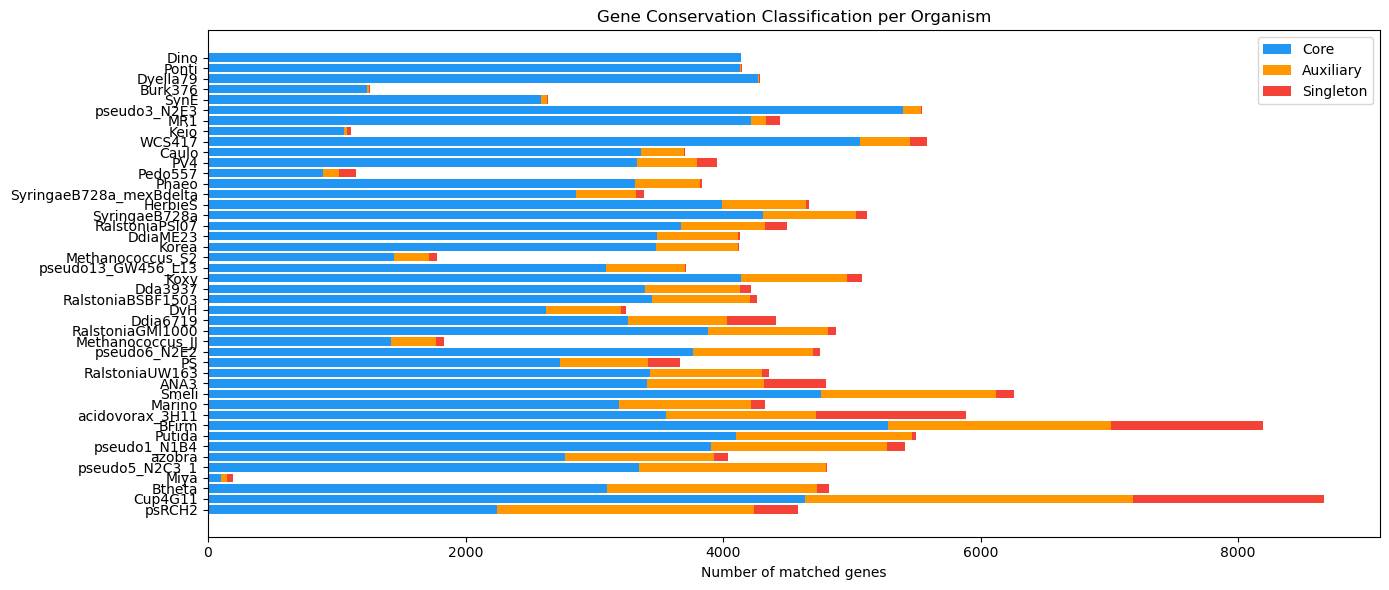

In [12]:
# Core/auxiliary/singleton breakdown per organism
if link_table['is_core'].notna().any():
    conservation_summary = link_table.groupby('orgId').agg(
        n_core=('is_core', 'sum'),
        n_auxiliary=('is_auxiliary', 'sum'),
        n_singleton=('is_singleton', 'sum'),
        n_total=('orgId', 'size')
    ).reset_index()
    
    conservation_summary['pct_core'] = (conservation_summary['n_core'] / 
                                         conservation_summary['n_total'] * 100).round(1)
    conservation_summary['pct_singleton'] = (conservation_summary['n_singleton'] / 
                                              conservation_summary['n_total'] * 100).round(1)
    
    print("=== CONSERVATION BREAKDOWN PER ORGANISM ===")
    print(conservation_summary.sort_values('orgId').to_string(index=False))
    
    # Stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    cs = conservation_summary.sort_values('pct_core', ascending=True)
    
    ax.barh(cs['orgId'], cs['n_core'], label='Core', color='#2196F3')
    ax.barh(cs['orgId'], cs['n_auxiliary'], left=cs['n_core'], 
            label='Auxiliary', color='#FF9800')
    ax.barh(cs['orgId'], cs['n_singleton'], 
            left=cs['n_core'] + cs['n_auxiliary'],
            label='Singleton', color='#F44336')
    
    ax.set_xlabel('Number of matched genes')
    ax.set_title('Gene Conservation Classification per Organism')
    ax.legend()
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'conservation_breakdown.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No conservation data available — run cluster_metadata export first")

In [13]:
# Spot-check: known organisms
spot_checks = [
    ('Putida', 'PP_0001'),    # P. putida chromosome partitioning
    ('Putida', 'PP_0002'),    # P. putida
    ('MR1', 'SO_0001'),       # Shewanella oneidensis MR-1
    ('MR1', 'SO_0002'),       # Shewanella
]

print("=== SPOT CHECKS ===")
for orgId, locusId in spot_checks:
    hit = link_table[(link_table['orgId'] == orgId) & (link_table['locusId'] == locusId)]
    if len(hit) > 0:
        h = hit.iloc[0]
        core_status = 'core' if h.get('is_core') else ('singleton' if h.get('is_singleton') else 'auxiliary')
        print(f"  {orgId}:{locusId} -> {h['gene_cluster_id']} "
              f"(pident={h['pident']:.1f}%, {core_status})")
    else:
        print(f"  {orgId}:{locusId} -> NO MATCH")

=== SPOT CHECKS ===
  Putida:PP_0001 -> DOAB01000360.1_6 (pident=99.2%, core)
  Putida:PP_0002 -> NZ_NHBB01000001.1_48 (pident=100.0%, core)
  MR1:SO_0001 -> NO MATCH
  MR1:SO_0002 -> NO MATCH


In [14]:
# Note E. coli exclusion
ecoli_orgs = ['Keio']  # E. coli BW25113
for org in ecoli_orgs:
    in_mapping = org in mapping['orgId'].values
    in_results = org in link_table['orgId'].values if len(link_table) > 0 else False
    print(f"E. coli check ({org}):")
    print(f"  In organism mapping: {in_mapping}")
    print(f"  In link table: {in_results}")
    if not in_mapping:
        print(f"  Reason: main s__Escherichia_coli clade absent from pangenome")
        print(f"  (too large — would have thousands of genomes)")

E. coli check (Keio):
  In organism mapping: True
  In link table: True


## 6. Summary & Promotion Decision

In [15]:
print("=" * 60)
print("NB03 SUMMARY")
print("=" * 60)
print(f"Link table: {len(link_table):,} rows")
print(f"Organisms: {link_table['orgId'].nunique()}")
print(f"Gene clusters: {link_table['gene_cluster_id'].nunique():,}")
print(f"")
print(f"Coverage: {summary['pct_matched'].median():.1f}% median across organisms")
print(f"Identity: {link_table['pident'].median():.1f}% median across all hits")
print(f"")
high_cov = (summary['pct_matched'] >= 90).sum()
print(f"Organisms with ≥90% coverage: {high_cov}/{len(summary)}")
print(f"")
if link_table['is_core'].notna().any():
    print(f"Conservation: {link_table['is_core'].sum():,} core, "
          f"{link_table['is_auxiliary'].sum():,} auxiliary, "
          f"{link_table['is_singleton'].sum():,} singleton")
print(f"")
print(f"Output: {output_path}")
print("=" * 60)

# Promotion decision
if summary['pct_matched'].median() >= 90 and link_table['pident'].median() >= 95:
    print("\n** Quality sufficient for promotion to data/fitnessbrowser_link/ **")
    print("Run: cp data/fb_pangenome_link.tsv ../../data/fitnessbrowser_link/")
else:
    print("\n** Quality below threshold for promotion — review issues above **")

NB03 SUMMARY
Link table: 177,863 rows
Organisms: 44
Gene clusters: 163,974

Coverage: 94.2% median across organisms
Identity: 100.0% median across all hits

Organisms with ≥90% coverage: 34/59

Conservation: 145,821 core, 32,042 auxiliary, 7,574 singleton

Output: ../data/fb_pangenome_link.tsv

** Quality sufficient for promotion to data/fitnessbrowser_link/ **
Run: cp data/fb_pangenome_link.tsv ../../data/fitnessbrowser_link/
